In [1]:
%matplotlib notebook
import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy,AUROC


import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

# from skimage.transform import resize

# torch.set_num_threads(3)

def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

SEED=1234
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
device='cpu'
DEVICE=device

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=256,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]


In [4]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3):
    metric = AUROC(task='binary', num_classes=2) 
    softmax = nn.Softmax(dim=1)
    
    training_accuracy = Accuracy(task='binary').to(DEVICE)
    val_accuracy = Accuracy(task='binary').to(DEVICE)

    manual_seed(1111)

    cnn_conf=Net()
    cnn_conf.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)


    loss_list_train=[]
    loss_list_val=[]
    acc_list_train=[]
    acc_list_va=[]
    

    min_loss = 1000000
#     last_loss = 1000000000
    models = []
    training_logs = []

    for training_ind in range(5):
        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f' epoch {epoch+1} in {epochs}')
            t0=time.time()
            epoch_loss = 0.0
            epoch_loss_val=0.0
            batch_acc=[]
            batch_acc_val=[]

            auroc_train=[]
            auroc_val=[]

            pred_train=[]
            pred_val=[]
            true_labels_train=[]
            true_labels_val=[]

            for i, data in enumerate(train_loader):
                inputs, labels = data

                inputs = inputs.to(DEVICE,dtype=torch.float)
                labels = labels.type(torch.LongTensor)
                labels=labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = cnn_conf(inputs).squeeze()
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()        
                batch_acc.append(training_accuracy(predicted, labels).item())

                pred_train=np.concatenate((pred_train, softmax(outputs)[:,1].cpu().detach().numpy()))
                true_labels_train=np.concatenate((true_labels_train, labels.cpu().numpy()))

            auroc_train=metric(torch.tensor(pred_train),torch.tensor(true_labels_train).to(torch.int32))

            for i_v, data_val in enumerate(val_loader):
                inputs_val, labels_val = data_val

                inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
                labels_val = labels_val.type(torch.LongTensor)
                labels_val=labels_val.to(DEVICE)

                outputs_val = cnn_conf(inputs_val).squeeze()
                _, predicted_val = torch.max(outputs_val.data, 1)

                loss_val = criterion(outputs_val, labels_val)

                epoch_loss_val += loss_val.item()        
                batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())


                pred_val=np.concatenate((pred_val, softmax(outputs_val)[:,1].cpu().detach().numpy()))
                true_labels_val=np.concatenate((true_labels_val, labels_val.cpu().detach().numpy()))

            if epoch_loss_val < min_loss:
                min_loss = epoch_loss_val
                save_model = type(cnn_conf)() # get a new instance
                save_model.load_state_dict(cnn_conf.state_dict()) # copy weights and stuff

                torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

            auroc_val=metric(torch.tensor(pred_val),torch.tensor(true_labels_val).to(torch.int32))

            epoch_acc=sum(batch_acc)/len(batch_acc)
            epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

            print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc} | AUROC: {auroc_train}')
            print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val} | AUROC: {auroc_val}')
            print(f'time elapsed: {round(time.time()-t0,2)} s')

            loss_list_train.append(epoch_loss)
            loss_list_val.append(epoch_loss_val)
            acc_list_train.append(epoch_acc)
            acc_list_va.append(epoch_acc_val)

            epoch_loss = 0.0
            epoch_loss_val=0.0

    print('Finished Training')
    print()
    print('\t \t *******************')
    print()
    
    torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

    models.append(save_model)
    training_logs.append([acc_list_train, loss_list_train, acc_list_val, loss_list_val])
#     plt.plot(loss_list_train)
#     plt.plot(loss_list_val)
#     plt.plot([i*100 for i in acc_list_train])
#     plt.plot([i*100 for i in acc_list_va])
    return trained_models, [acc_list_train, loss_list_train, acc_list_val, loss_list_val]

In [5]:
cnn=Net()

In [12]:
with open('confounder_train128.pkl', 'rb') as f:
    confounder_train = pickle.load(f)
    confounder_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_train]
print('train')

with open('confounder_val128.pkl', 'rb') as f:
    confounder_val = pickle.load(f)
    confounder_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_val]
print('val')

with open('confounder_test128.pkl', 'rb') as f:
    confounder_test = pickle.load(f)
    confounder_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_test]
print('test')


train
val
test


In [7]:
len(confounder_val)

3000

Text(0.5, 1.0, 'target: 1')

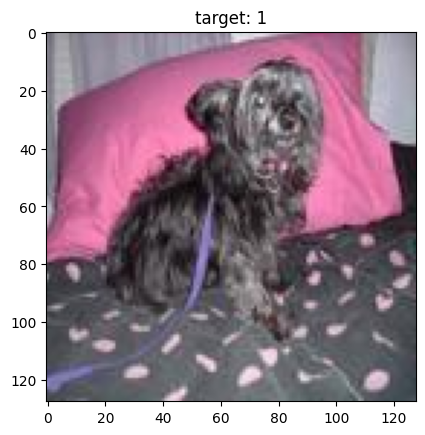

In [8]:
n=3000
plt.imshow(confounder_train[n][0].transpose(1,2,0))
plt.title('target: '+str(confounder_train[n][1]))

# Confounder

In [7]:
batch_size=64
manual_seed(0)
confounder_train_loader = DataLoader(confounder_train,batch_size=batch_size, shuffle=True)
confounder_val_loader = DataLoader(confounder_val,batch_size=batch_size, shuffle=True)
confounder_hold_loader = DataLoader(confounder_test,batch_size=batch_size, shuffle=False)

lr=0.005
epochs=40

conf_models, conf_logs = train(lr,epochs,confounder_train_loader,confounder_val_loader,'cnn_conf',weight_decay=0.005)

 epoch 1 in 40


KeyboardInterrupt: 

# Suppressor

In [11]:


with open('suppressor_train128.pkl', 'rb') as f:
    supressor_train = pickle.load(f)
    supressor_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_train]
print('train')

with open('suppressor_validation128.pkl', 'rb') as f:
    supressor_val = pickle.load(f)
    supressor_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_val]
print('val')

with open('suppressor_test128.pkl', 'rb') as f:
    supressor_test = pickle.load(f)
    supressor_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_test]
print('test')


train
val
test


In [44]:
supressor_train[0][0].shape

(3, 128, 128)

 epoch 1 in 33
epoch train loss: 65.21498256921768 | epoch train acc 0.5048758863134587 | AUROC: 0.5052058696746826
epoch val loss: 20.78905439376831 | epoch val acc 0.49947916666666664 | AUROC: 0.5249041318893433
time elapsed: 3.63 s
 epoch 2 in 33
epoch train loss: 65.13729876279831 | epoch train acc 0.5052637413461157 | AUROC: 0.5130666494369507
epoch val loss: 20.78379911184311 | epoch val acc 0.5050189395745596 | AUROC: 0.547781765460968
time elapsed: 3.48 s
 epoch 3 in 33
epoch train loss: 65.11876142024994 | epoch train acc 0.5103612589709302 | AUROC: 0.5231359004974365
epoch val loss: 20.77542632818222 | epoch val acc 0.508617423971494 | AUROC: 0.5659396052360535
time elapsed: 3.68 s
 epoch 4 in 33
epoch train loss: 65.10551089048386 | epoch train acc 0.5129654255319149 | AUROC: 0.5258025527000427
epoch val loss: 20.779883205890656 | epoch val acc 0.5192234853903452 | AUROC: 0.5398520231246948
time elapsed: 3.64 s
 epoch 5 in 33
epoch train loss: 65.06870096921921 | epoch train

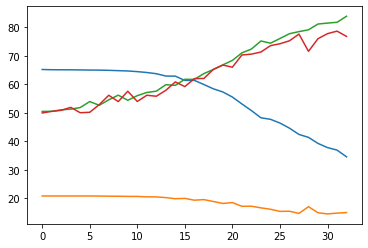

In [13]:
batch_size=64
manual_seed(0)
supressor_train_loader = DataLoader(supressor_train,batch_size=batch_size, shuffle=True)
supressor_val_loader = DataLoader(supressor_val,batch_size=batch_size, shuffle=True)
supressor_hold_loader = DataLoader(supressor_test,batch_size=batch_size, shuffle=False)

lr=0.005
epochs=33


cnn_sup=train(lr,epochs,supressor_train_loader,supressor_val_loader,'cnn_sup',weight_decay=0.001)


In [14]:
cnn_sup

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxPooling2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (adPooling): AdaptiveAvgPool1d(output_size=256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

# No watermark

In [13]:


with open('no_mark_train128.pkl', 'rb') as f:
    no_mark_train = pickle.load(f)
    no_mark_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_train]
print('train')

with open('no_mark_validation128.pkl', 'rb') as f:
    no_mark_val = pickle.load(f)
    no_mark_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_val]
print('val')

with open('no_mark_test128.pkl', 'rb') as f:
    no_mark_test = pickle.load(f)
    no_mark_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_test]
print('test')


train
val
test


 epoch 1 in 40
epoch train loss: 65.21521204710007 | epoch train acc 0.5022163118453736 | AUROC: 0.5048913955688477
epoch val loss: 20.78926718235016 | epoch val acc 0.4979166666666667 | AUROC: 0.5246094465255737
time elapsed: 4.09 s
 epoch 2 in 40
epoch train loss: 65.14060115814209 | epoch train acc 0.5044880319148937 | AUROC: 0.5114642381668091
epoch val loss: 20.78463214635849 | epoch val acc 0.5050189395745596 | AUROC: 0.5473130345344543
time elapsed: 3.48 s
 epoch 3 in 40
epoch train loss: 65.12382912635803 | epoch train acc 0.5097517729439633 | AUROC: 0.5214186906814575
epoch val loss: 20.779552400112152 | epoch val acc 0.5013257573048274 | AUROC: 0.561129093170166
time elapsed: 3.77 s
 epoch 4 in 40
epoch train loss: 65.11752277612686 | epoch train acc 0.5105274820581396 | AUROC: 0.5220681428909302
epoch val loss: 20.784019589424133 | epoch val acc 0.5111742417017618 | AUROC: 0.5351811051368713
time elapsed: 3.75 s
 epoch 5 in 40
epoch train loss: 65.0942297577858 | epoch train

epoch train loss: 41.788033455610275 | epoch train acc 0.7895057626227115 | AUROC: 0.8743520975112915
epoch val loss: 16.06894126534462 | epoch val acc 0.7471117417017619 | AUROC: 0.82234787940979
time elapsed: 3.59 s
 epoch 37 in 40
epoch train loss: 39.50071105360985 | epoch train acc 0.8091201243248392 | AUROC: 0.8903541564941406
epoch val loss: 14.967585861682892 | epoch val acc 0.7691761354605356 | AUROC: 0.8502382636070251
time elapsed: 3.63 s
 epoch 38 in 40
epoch train loss: 39.0114531069994 | epoch train acc 0.8081227838993073 | AUROC: 0.8926495313644409
epoch val loss: 15.618636965751648 | epoch val acc 0.7547348479429881 | AUROC: 0.8584010601043701
time elapsed: 3.52 s
 epoch 39 in 40
epoch train loss: 37.28183379769325 | epoch train acc 0.8202570924099456 | AUROC: 0.9034926295280457
epoch val loss: 15.121626675128937 | epoch val acc 0.7556818187236786 | AUROC: 0.8575755953788757
time elapsed: 3.7 s
 epoch 40 in 40
epoch train loss: 35.13474132120609 | epoch train acc 0.8354

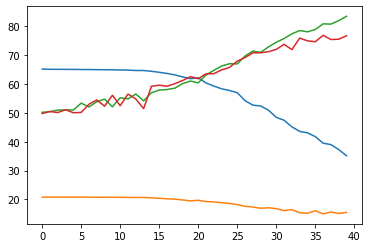

In [16]:
batch_size=64
manual_seed(0)
no_mark_train_loader = DataLoader(no_mark_train,batch_size=batch_size, shuffle=True)
no_mark_val_loader = DataLoader(no_mark_val,batch_size=batch_size, shuffle=False)
no_mark_test_loader = DataLoader(no_mark_test,batch_size=batch_size, shuffle=False)

lr=0.005
epochs=40
cnn_no=train(lr,epochs,supressor_train_loader,supressor_val_loader,'cnn_no',weight_decay=0.003)


# AUC

In [8]:
true_labels=np.array([])

for i_v, data_val in enumerate(confounder_hold_loader):
    inputs_val, labels_val = data_val
    inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
    labels_val = labels_val.type(torch.LongTensor)
    labels_val=labels_val.to(DEVICE)
    
    true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))

true_labels

array([0., 0., 0., ..., 1., 1., 1.])

In [9]:
def load_trained(path):
    model = Net()
    model.load_state_dict(torch.load(path,map_location=device))
    return model

def print_AUC(loader, model_ind=0):

    cnn_conf=load_trained(f'./cnn_conf_{model_ind}.pt').to(device)
    cnn_sup=load_trained(f'./cnn_sup_{model_ind}.pt').to(device)
    cnn_no=load_trained(f'./cnn_no_{model_ind}.pt').to(device)
    
    #models -> cnn_no; cnn_sup; cnn_conf

    softmax = nn.Softmax(dim=1)
    metric = AUROC(num_classes=2, task='binary')

    model_conf_test_conf_pred=np.array([])
    model_sup_test_conf_pred=np.array([])
    model_no_test_conf_pred=np.array([])
    true_labels=np.array([])

    for i_v, data_val in enumerate(loader):
        inputs_val, labels_val = data_val
        inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
        labels_val = labels_val.type(torch.LongTensor)
        labels_val=labels_val.to(DEVICE)

        outputs_conf = cnn_conf(inputs_val).squeeze()
        outputs_sup = cnn_sup(inputs_val).squeeze()
        outputs_no = cnn_no(inputs_val).squeeze()

        out_pred_conf=softmax(outputs_conf)
        out_pred_sup=softmax(outputs_sup)
        out_pred_no=softmax(outputs_no)

        model_conf_test_conf_pred=np.concatenate((model_conf_test_conf_pred, out_pred_conf[:,1].cpu().detach().numpy()))
        model_sup_test_conf_pred=np.concatenate((model_sup_test_conf_pred, out_pred_sup[:,1].cpu().detach().numpy()))
        model_no_test_conf_pred=np.concatenate((model_no_test_conf_pred, out_pred_no[:,1].cpu().detach().numpy()))
        true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))

    print('model: confounder',metric(torch.tensor(model_conf_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
    print('model: supressor',metric(torch.tensor(model_sup_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
    print('model: no watermark',metric(torch.tensor(model_no_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
    print()

    l=[metric(torch.tensor(model_conf_test_conf_pred),torch.tensor(true_labels).to(torch.int32)),
       metric(torch.tensor(model_sup_test_conf_pred),torch.tensor(true_labels).to(torch.int32)),
       metric(torch.tensor(model_no_test_conf_pred),torch.tensor(true_labels).to(torch.int32))]
    return l


In [14]:
batch_size=64
confounder_test_loader = DataLoader(confounder_test,batch_size=batch_size, shuffle=False)
supressor_test_loader = DataLoader(supressor_test,batch_size=batch_size, shuffle=False)
no_mark_test_loader = DataLoader(no_mark_test,batch_size=batch_size, shuffle=False)

confounder_data_results = []
suppressor_data_results = []
no_mark_data_results = []

for i in range(5):
    print(f'MODEL {i}')
    print('confounder data:')
    confounder_data_results.append(print_AUC(confounder_test_loader, i))
    print()
    print('suppressor data:')
    suppressor_data_results.append(print_AUC(supressor_test_loader, i))
    print()
    print('no watermark data:')
    no_mark_data_results.append(print_AUC(no_mark_test_loader, i))
    print()

MODEL 0
confounder data:


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 251920384 bytes.

In [13]:
confounder_data_results

[[tensor(0.9438), tensor(0.9318), tensor(0.8875)],
 [tensor(0.9418), tensor(0.9322), tensor(0.8912)],
 [tensor(0.9460), tensor(0.9352), tensor(0.8900)],
 [tensor(0.9425), tensor(0.9338), tensor(0.9230)],
 [tensor(0.9425), tensor(0.9302), tensor(0.9244)]]

In [17]:
torch.mean(torch.tensor(confounder_data_results), axis=0)

tensor([0.9433, 0.9326, 0.9032])

In [18]:
torch.mean(torch.tensor(suppressor_data_results), axis=0)

tensor([0.8469, 0.9312, 0.9250])

In [19]:
torch.mean(torch.tensor(no_mark_data_results), axis=0)

tensor([0.9017, 0.9395, 0.9610])